('__version__', '1.0')
('__header__', 'MATLAB 5.0 MAT-file, written by Octave 2.9.12, 2008-06-11 11:23:43 UTC')
('truth', array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))
('__globals__', [])


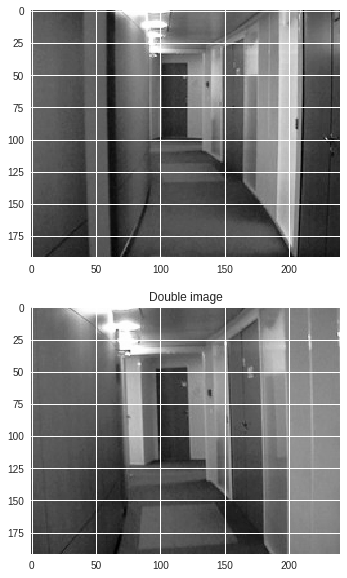

[2]
Press Enter to continue...
/home/sastrygrp2/code/loop_closures/data/Lip6IndoorDataSet/Images/0068.jpg
/home/sastrygrp2/code/loop_closures/data/Lip6IndoorDataSet/Images/0001.jpg


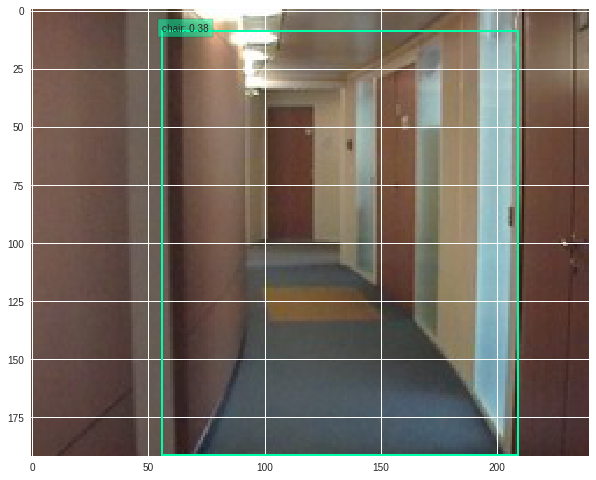

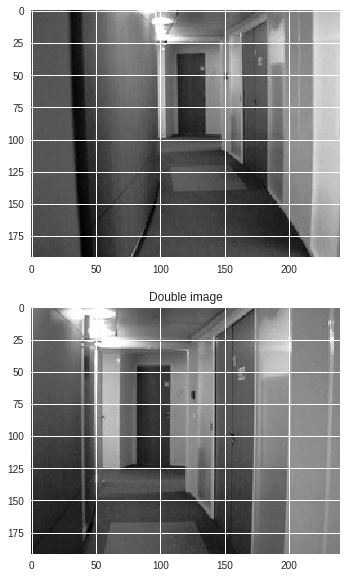

[0]


In [ ]:

import matplotlib

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.io as sio
import numpy as np

from PIL import Image
import pylab 
import matplotlib.cm as cm 

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '/home/sastrygrp2/code/3rd_party/ssd_net/caffe/'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

#GROUND_TRUTH_PATH = os.path.expanduser(
#    '~/code/loop_closures/data/NewCollegeGroundTruth.mat')




from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/VOC0712/labelmap_voc.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames


model_def = 'models/VGGNet/VOC0712/SSD_300x300/deploy.prototxt'
model_weights = 'models/VGGNet/VOC0712/SSD_300x300/VGG_VOC0712_SSD_300x300_iter_120000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

GROUND_TRUTH_PATH = os.path.expanduser(
    '~/code/loop_closures/data/Lip6IndoorDataSet/Lip6IndoorGroundTruth.mat')
 
#get ground truth data
temp = sio.loadmat(GROUND_TRUTH_PATH)
gt_data = sio.loadmat(GROUND_TRUTH_PATH)['truth']

for keys in temp.items():
    print(keys)
    
indices = np.where(gt_data == 1)
#print(indices)
m_key = indices[0]
m_value = indices[1]

m_dict = dict(zip(m_key,m_value));
#print(m_dict)

for key, value in m_dict.items():
    
    name1 = '%04d' % (key,)
    name2 = '%04d' % (value,)
    
    name1 = '/home/sastrygrp2/code/loop_closures/data/Lip6IndoorDataSet/Images/' + name1 +'.jpg'
    name2 = '/home/sastrygrp2/code/loop_closures/data/Lip6IndoorDataSet/Images/' + name2 +'.jpg'
    
    
    f = pylab.figure()
    for n, fname in enumerate((name1, name2)):
        image=Image.open(fname).convert("L")
        arr=np.asarray(image)
        f.add_subplot(2, 1, n+1)  # this line outputs images on top of each other
        # f.add_subplot(1, 2, n)  # this line outputs images side-by-side
        pylab.imshow(arr,cmap=cm.Greys_r)
    pylab.title('Double image')
    pylab.show()
    
    image_resize = 300
    net.blobs['data'].reshape(1,3,image_resize,image_resize)

    image = caffe.io.load_image(name1)
    plt.imshow(image)
    
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image

    # Forward pass.
    detections = net.forward()['detection_out']

    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    print(top_indices)

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(image)
    currentAxis = plt.gca()

    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

    raw_input("Press Enter to continue...")
  
  
    print(name1)
    print(name2)
    